Intro

In [206]:
import numpy as np 
import pandas as pd  
import seaborn as sns 
import matplotlib.pyplot as plt
import mpu
from sklearn.neighbors import LocalOutlierFactor
%matplotlib inline 

In [207]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [208]:
train_df = pd.read_csv(r"C:\Users\arind\OneDrive\Desktop\Kaggle Challenges\train.csv")
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,14-03-2016 17:24,14-03-2016 17:32,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,12-06-2016 00:43,12-06-2016 00:54,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,19-01-2016 11:35,19-01-2016 12:10,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,06-04-2016 19:32,06-04-2016 19:39,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,26-03-2016 13:30,26-03-2016 13:38,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [209]:
(train_df).isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [210]:
train_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.534503e+00,1.664382e+00,-7.397342e+01,4.075094e+01,-7.397336e+01,4.075183e+01,9.621448e+02
std,4.988084e-01,1.314261e+00,4.280165e-02,3.381389e-02,4.274282e-02,3.645002e-02,5.853002e+03
min,1.000000e+00,0.000000e+00,-7.854740e+01,3.435970e+01,-7.981798e+01,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399186e+01,4.073738e+01,-7.399131e+01,4.073594e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075415e+01,-7.397973e+01,4.075455e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396731e+01,4.076836e+01,-7.396301e+01,4.076984e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.391176e+01,3.526282e+06


Dataset has no missing values

In [211]:
train_df['distance'] = haversine_np(train_df['pickup_longitude'],train_df['pickup_latitude'],
                                    train_df['dropoff_longitude'],train_df['dropoff_latitude']) 

In [212]:
#Considering trips ranging from 1 min to 120 mins only
train_df = train_df[(train_df['trip_duration']>60) &  (train_df['trip_duration']<7200)]
#Considering trips only below 20 km
train_df = train_df[(train_df['distance']<20)]
#Considering trips only above 0.1 km
train_df = train_df[(train_df['distance']>.1)]
#Removing 0 passenger rides
train_df = train_df[train_df['passenger_count']!=0]

<AxesSubplot:xlabel='dropoff_longitude', ylabel='dropoff_latitude'>

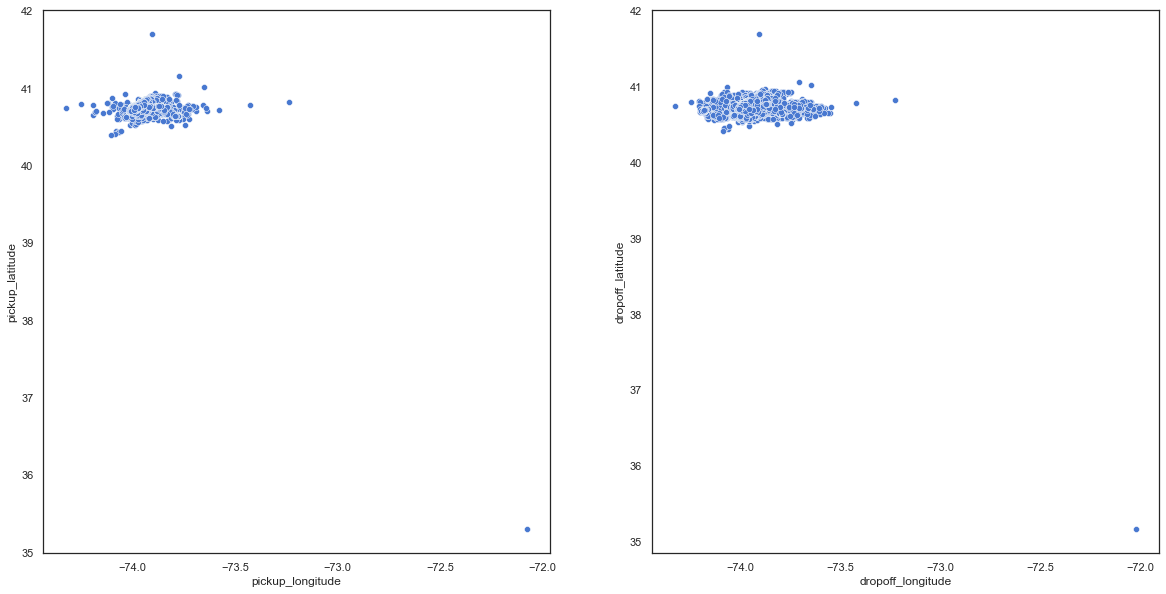

In [213]:
# Plotting for pickup & dropoff locations
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 2, figsize=(20,10), sharex=False)
sns.scatterplot(data=train_df,y = 'pickup_latitude',x='pickup_longitude', ax=axes[0])
sns.scatterplot(data=train_df,y = 'dropoff_latitude',x='dropoff_longitude', ax=axes[1])

In [214]:
# Removing absurd geo-coordinates 
lat_max = train_df['pickup_latitude'].mean() + train_df['pickup_latitude'].std()*5
lat_min = train_df['pickup_latitude'].mean() - train_df['pickup_latitude'].std()*5
train_df = train_df[(train_df['pickup_latitude']>lat_min) & (train_df['pickup_latitude']<lat_max)]
lat_max = train_df['dropoff_latitude'].mean() + train_df['dropoff_latitude'].std()*5
lat_min = train_df['dropoff_latitude'].mean() - train_df['dropoff_latitude'].std()*5
train_df = train_df[(train_df['dropoff_latitude']>lat_min) & (train_df['dropoff_latitude']<lat_max)]
# Refer to notebook https://www.kaggle.com/jeru666/modeling-after-removing-outliers-gradient-boost

<AxesSubplot:xlabel='dropoff_longitude', ylabel='dropoff_latitude'>

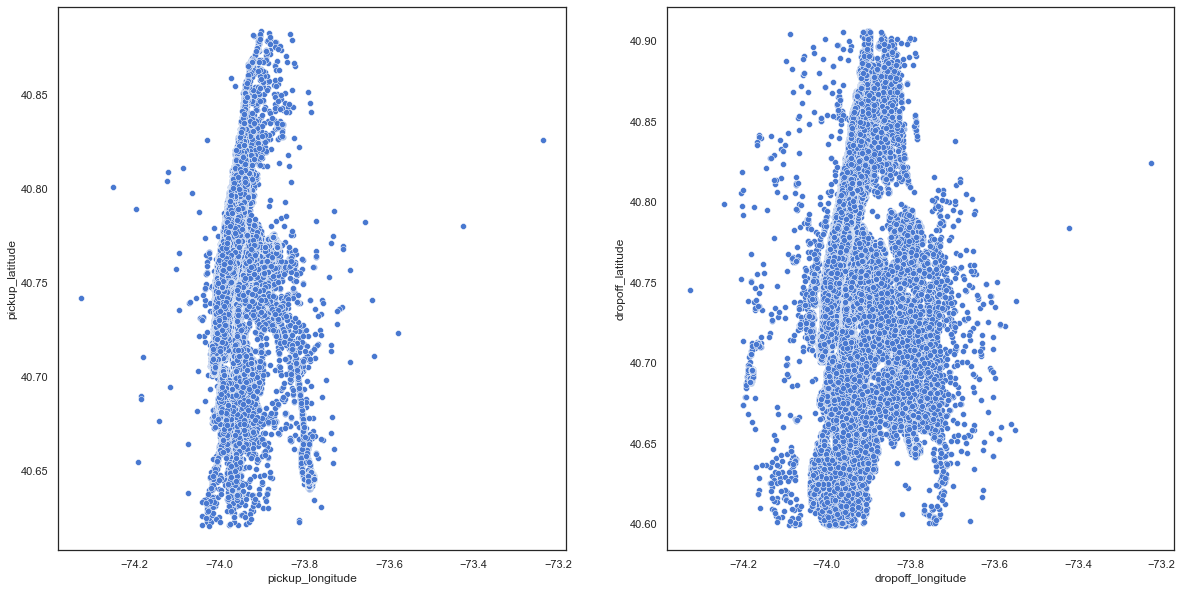

In [215]:
# Plotting for pickup & dropoff locations
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 2, figsize=(20,10), sharex=False)
sns.scatterplot(data=train_df,y = 'pickup_latitude',x='pickup_longitude', ax=axes[0])
sns.scatterplot(data=train_df,y = 'dropoff_latitude',x='dropoff_longitude', ax=axes[1])

In [216]:
#removing distance outliers
dist_max = train_df['distance'].mean() + train_df['distance'].std()*2
dist_min = train_df['distance'].mean() - train_df['distance'].std()*2
train_df = train_df[(train_df['distance']>dist_min) & (train_df['distance']<dist_max)]
trip_duration_max = train_df['trip_duration'].mean() + train_df['trip_duration'].std()*2
trip_duration_min = train_df['trip_duration'].mean() - train_df['trip_duration'].std()*2
train_df = train_df[(train_df['trip_duration']>trip_duration_min) & (train_df['trip_duration']<trip_duration_max)]

(918210, 12)


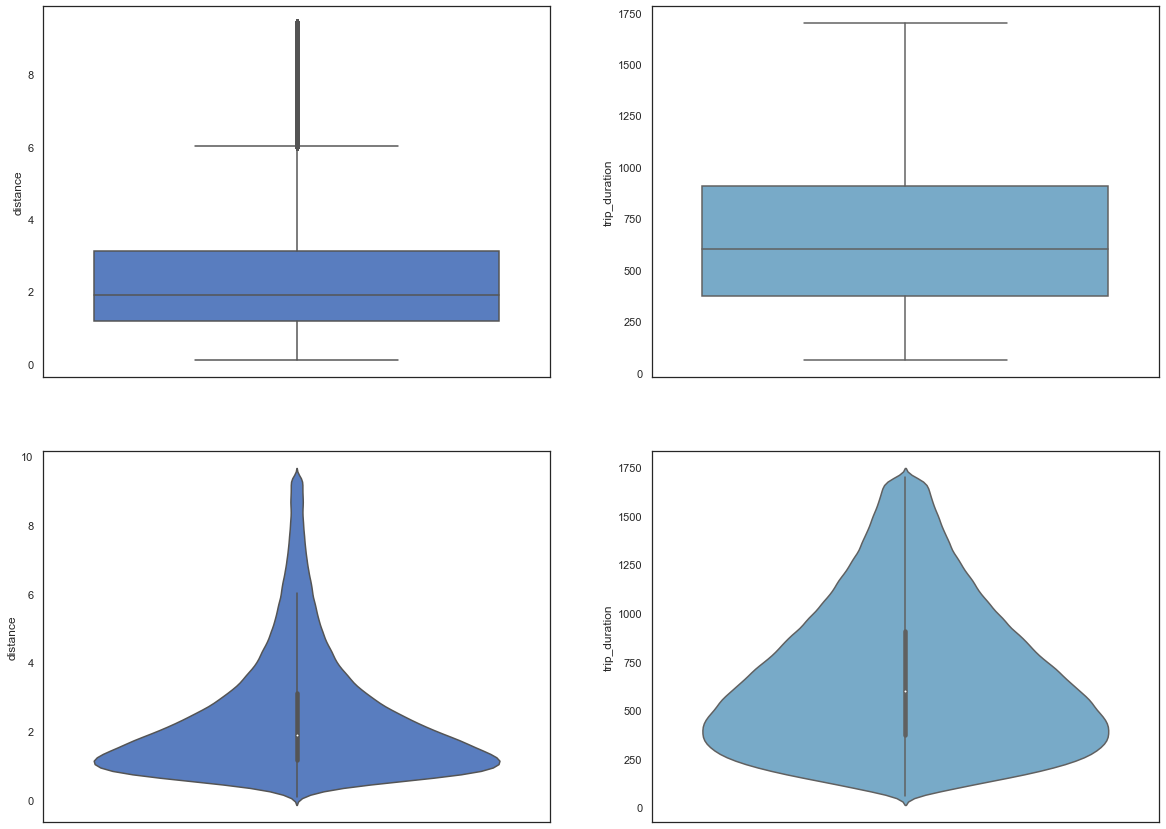

In [217]:
#Checking for outliers 
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2, 2, figsize=(20,15), sharex=False)
sns.boxplot(data=train_df,y='distance', ax=axes[0,0])
sns.boxplot(data=train_df,y='trip_duration', ax=axes[0,1],palette="Blues")
sns.violinplot(data=train_df,y='distance', ax=axes[1,0])
sns.violinplot(data=train_df,y='trip_duration', ax=axes[1,1],palette="Blues")
print(train_df.shape)

We still have outliers 

In [218]:
#Removing distance outliers
train_df = train_df[train_df['distance']<6]

(865555, 12)


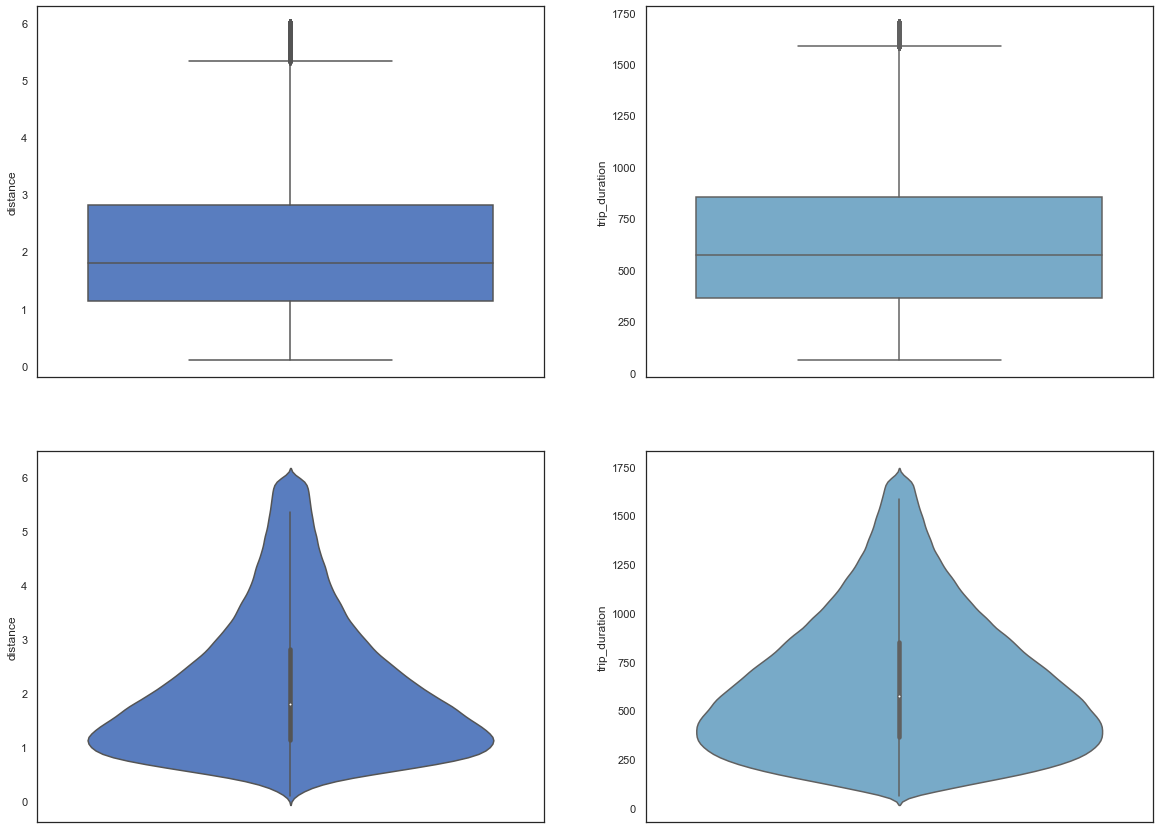

In [219]:
#Checking for outliers 
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2, 2, figsize=(20,15), sharex=False)
sns.boxplot(data=train_df,y='distance', ax=axes[0,0])
sns.boxplot(data=train_df,y='trip_duration', ax=axes[0,1],palette="Blues")
sns.violinplot(data=train_df,y='distance', ax=axes[1,0])
sns.violinplot(data=train_df,y='trip_duration', ax=axes[1,1],palette="Blues")
print(train_df.shape)

Seems Workable

Distance

<AxesSubplot:xlabel='distance', ylabel='Count'>

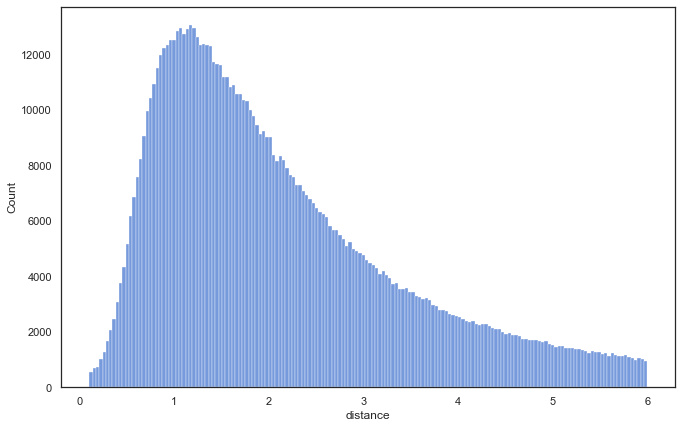

In [220]:
#Distance vs Trip Duration
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.histplot(x=train_df['distance'])

In [33]:

# To analyse by distance 
# To analyse by time 